<a href="https://colab.research.google.com/github/bishan5/A-Predictive-Traffic-Flow-Modelling-for-ITS/blob/main/24hrs_MultivariateLSTMModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Import Necessary Libraries**

In [1]:
# Basic data manipulation and numerical operations
import numpy as np
import pandas as pd

# Machine learning tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Deep learning imports - TensorFlow and Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Google Colab specific
from google.colab import files
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
FILE_PATH = '/content/drive/MyDrive/Clean_Metro_Interstate_Traffic_Volume.csv'
data = pd.read_csv(FILE_PATH)

In [4]:
data

,Timestamp,Traffic_volume,Holiday,Temp,Rain_1h,Snow_1h,Clouds_all,Weather_main,weather_description
0,01/07/2015 00:00,737,NaN,289.20,0.0,0.0,1.0,Clear,sky is clear
1,01/07/2015 01:00,444,NaN,289.40,0.0,0.0,1.0,Clear,sky is clear
2,01/07/2015 02:00,347,NaN,289.19,0.0,0.0,1.0,Clear,sky is clear
3,01/07/2015 03:00,356,NaN,288.74,0.3,0.0,1.0,Rain,light rain
4,01/07/2015 04:00,936,NaN,288.07,0.0,0.0,1.0,Clear,sky is clear
...,...,...,...,...,...,...,...,...,...
28507,30/09/2018 19:00,3543,NaN,283.45,0.0,0.0,75.0,Clouds,broken clouds
28508,30/09/2018 20:00,2781,NaN,282.76,0.0,0.0,90.0,Clouds,overcast clouds
28509,30/09/2018 21:00,2159,NaN,282.73,0.0,0.0,90.0,Thunderstorm,proximity thunderstorm
28510,30/09/2018 22:00,1450,NaN,282.09,0.0,0.0,90.0,Clouds,overcast clouds


<ipython-input-5-1800c1f1d88e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['Day_Type'] = recent_data['Timestamp'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
<ipython-input-5-1800c1f1d88e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['Day_Label'] = recent_data['Timestamp'].dt.strftime('%a %b %d %H:%M')  # Format: 'Day Month Date Hour:Minute'


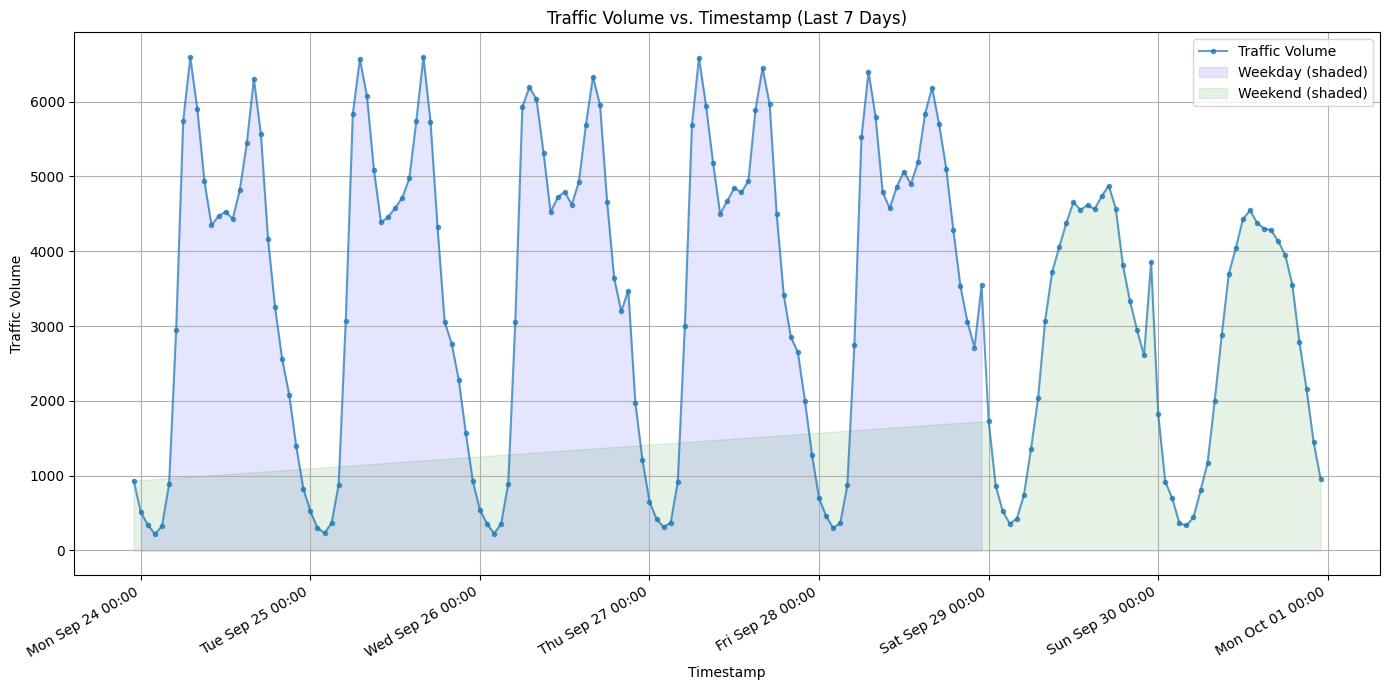

In [5]:
# Convert the 'Timestamp' column to datetime objects
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d/%m/%Y %H:%M')

# Filter data for the last 7 days
last_7_days = data['Timestamp'].max() - pd.Timedelta(days=7)
recent_data = data[data['Timestamp'] >= last_7_days]

# Identify weekdays and weekends
recent_data['Day_Type'] = recent_data['Timestamp'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Add the day of the week to the x-axis labels
recent_data['Day_Label'] = recent_data['Timestamp'].dt.strftime('%a %b %d %H:%M')  # Format: 'Day Month Date Hour:Minute'

# Create the plot
plt.figure(figsize=(14, 7))

# Plot traffic volume
plt.plot(recent_data['Timestamp'], recent_data['Traffic_volume'], label='Traffic Volume', alpha=0.7, linestyle='-', marker='o', markersize=3)

# Color-code weekdays and weekends
for day_type in ['Weekday', 'Weekend']:
    filtered_data = recent_data[recent_data['Day_Type'] == day_type]
    plt.fill_between(
        filtered_data['Timestamp'],
        0,
        filtered_data['Traffic_volume'],
        alpha=0.1,
        label=f'{day_type} (shaded)',
        color='blue' if day_type == 'Weekday' else 'green'
    )

# Format x-axis to show day labels
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a %b %d %H:%M'))  # Format includes day

# Enhance the plot
plt.xlabel('Timestamp')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume vs. Timestamp (Last 7 Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


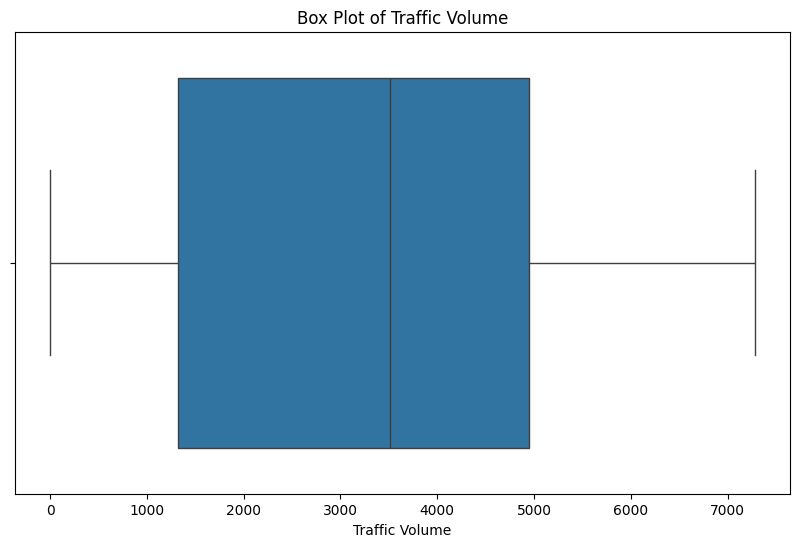

In [6]:
# create box plot

plt.figure(figsize=(10, 6))
sns.boxplot(x='Traffic_volume', data=data)
plt.title('Box Plot of Traffic Volume')
plt.xlabel('Traffic Volume')
plt.show()

In [7]:
# Calculate the first quartile (Q1) and third quartile (Q3) of the traffic volume
Q1 = data['Traffic_volume'].quantile(0.25)
Q3 = data['Traffic_volume'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
data = data[~((data['Traffic_volume'] < lower_bound) | (data['Traffic_volume'] > upper_bound))]



**Feature extraction**

In [8]:
# Convert 'Holiday' column values: NaN to 0, others to 1
data['Holiday'] = data['Holiday'].apply(lambda x: 0 if pd.isna(x) else 1)


In [9]:
# Convert 'Timestamp' to datetime and extract features
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d/%m/%Y %H:%M')
data['Hour'] = data['Timestamp'].dt.hour
data['Day'] = data['Timestamp'].dt.day
data['Weekday'] = data['Timestamp'].dt.weekday
data['Is_night'] = data['Hour'].isin([22,23,0,1,2,3,4,5])
data['Month'] = data['Timestamp'].dt.month
data['Is_weekend'] = data['Weekday'].isin([5, 6])
data['Year'] = data['Timestamp'].dt.year

In [10]:
data.head()

,Timestamp,Traffic_volume,Holiday,Temp,Rain_1h,Snow_1h,Clouds_all,Weather_main,weather_description,Hour,Day,Weekday,Is_night,Month,Is_weekend,Year
0,2015-07-01 00:00:00,737,0,289.20,0.0,0.0,1.0,Clear,sky is clear,0,1,2,True,7,False,2015
1,2015-07-01 01:00:00,444,0,289.40,0.0,0.0,1.0,Clear,sky is clear,1,1,2,True,7,False,2015
2,2015-07-01 02:00:00,347,0,289.19,0.0,0.0,1.0,Clear,sky is clear,2,1,2,True,7,False,2015
3,2015-07-01 03:00:00,356,0,288.74,0.3,0.0,1.0,Rain,light rain,3,1,2,True,7,False,2015
4,2015-07-01 04:00:00,936,0,288.07,0.0,0.0,1.0,Clear,sky is clear,4,1,2,True,7,False,2015


In [11]:
# 1. Encode 'Year' (Ordinal Encoding from 2015 to 2018)
data['Year'] = data['Year'] -2015
data['Is_weekend'] = data['Is_weekend'].astype(int)
data['Is_night'] = data['Is_night'].astype(int)


label_encoder = LabelEncoder()
data['Weather_main'] = label_encoder.fit_transform(data['Weather_main'])

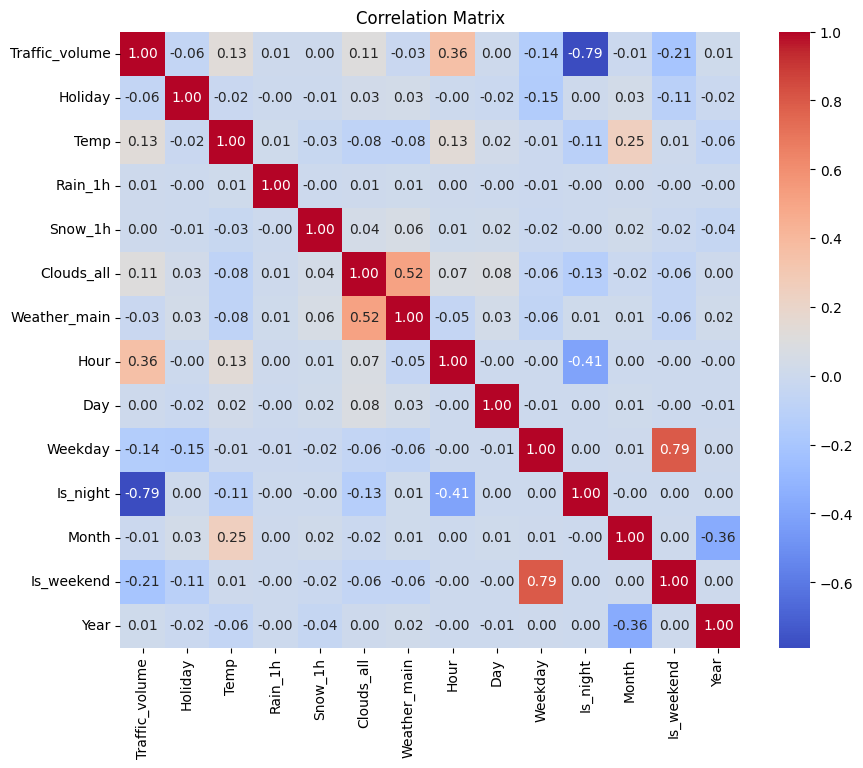

In [12]:
plt.figure(figsize=(10, 8))
# Select only numeric columns for correlation calculation
numeric_data = data.select_dtypes(include=['number'])
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [13]:
# List of features to use for prediction
features = ['Traffic_volume', 'Hour', 'Weekday', 'Temp', 'Weather_main', 'Clouds_all', 'Is_weekend', 'Is_night']

# Target variable
target = 'Traffic_volume'

**Step 2: Prepare the Data**

In [14]:
# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Select the features from the DataFrame
X = data[features]

# Apply scaling to the feature data
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(data[target].values.reshape(-1, 1))

In [15]:
# Function to create sequences with lookback and predict next 24 hours
look_back = 24  # Use past 24 hours for prediction
n_hours_to_predict = 24  # Predict the next 24 hours

def create_dataset(features, target, look_back=1, n_hours_to_predict=3):
    X, y = [], []
    for i in range(len(features) - look_back - n_hours_to_predict + 1):
        X.append(features[i:i + look_back])
        y.append(target[i + look_back:i + look_back + n_hours_to_predict])
    return np.array(X), np.array(y)

X, y = create_dataset(X_scaled, y_scaled, look_back, n_hours_to_predict)

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")



Training data shape: (22772, 24, 8), (22772, 24, 1)
Testing data shape: (5693, 24, 8), (5693, 24, 1)


**Step 3: Build the LSTM Model**

In [16]:
# Build the LSTM Model

def build_lstm_model(input_shape):
    model = Sequential()

    # First LSTM layer with dropout
    model.add(LSTM(224, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.4))

    # Second LSTM layer with dropout
    model.add(LSTM(160, return_sequences=False))
    model.add(Dropout(0.4))

    # Dense layer
    model.add(Dense(48, activation='relu'))

    # Output layer for predicting the next 24 hours
    model.add(Dense(24))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model

# Build and compile the model
model = build_lstm_model(input_shape=(look_back, X_train.shape[2]))

# Summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 224)           208768    
                                                                 
 dropout (Dropout)           (None, 24, 224)           0         
                                                                 
 lstm_1 (LSTM)               (None, 160)               246400    
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense (Dense)               (None, 48)                7728      
                                                                 
 dense_1 (Dense)             (None, 24)                1176      
                                                                 
Total params: 464,072
Trainable params: 464,072
Non-trai

In [17]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
570/570 [==============================] - 56s 92ms/step - loss: 0.0251 - mae: 0.1158 - val_loss: 0.0091 - val_mae: 0.0684 - lr: 0.0010
Epoch 2/100
570/570 [==============================] - 49s 86ms/step - loss: 0.0104 - mae: 0.0751 - val_loss: 0.0072 - val_mae: 0.0598 - lr: 0.0010
Epoch 3/100
570/570 [==============================] - 49s 86ms/step - loss: 0.0082 - mae: 0.0653 - val_loss: 0.0059 - val_mae: 0.0510 - lr: 0.0010
Epoch 4/100
570/570 [==============================] - 49s 86ms/step - loss: 0.0071 - mae: 0.0598 - val_loss: 0.0052 - val_mae: 0.0466 - lr: 0.0010
Epoch 5/100
570/570 [==============================] - 49s 86ms/step - loss: 0.0064 - mae: 0.0565 - val_loss: 0.0051 - val_mae: 0.0454 - lr: 0.0010
Epoch 6/100
570/570 [==============================] - 49s 85ms/step - loss: 0.0061 - mae: 0.0548 - val_loss: 0.0050 - val_mae: 0.0443 - lr: 0.0010
Epoch 7/100
570/570 [==============================] - 49s 86ms/step - loss: 0.0058 - mae: 0.0534 - val_loss: 0.

In [18]:
# Predictions for train and test sets
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

178/178 [==============================] - 4s 22ms/step


In [19]:
# Reshape predictions and targets
train_predict_reshaped = train_predict.reshape(-1, 24)
test_predict_reshaped = test_predict.reshape(-1, 24)
y_train_reshaped = y_train.reshape(-1, 24)
y_test_reshaped = y_test.reshape(-1, 24)

In [20]:
# Reverse scaling to get actual values
y_train_rescaled = scaler_y.inverse_transform(y_train_reshaped)
train_predict_rescaled = scaler_y.inverse_transform(train_predict_reshaped)
y_test_rescaled = scaler_y.inverse_transform(y_test_reshaped)
test_predict_rescaled = scaler_y.inverse_transform(test_predict_reshaped)

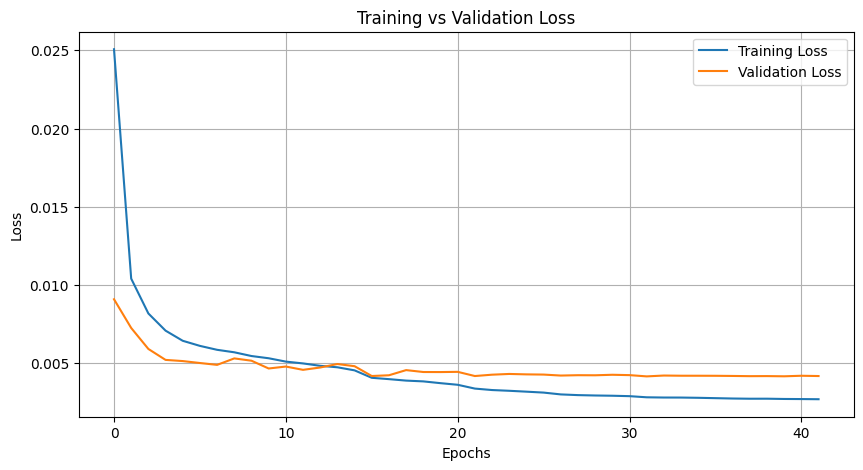

In [21]:
# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.show()

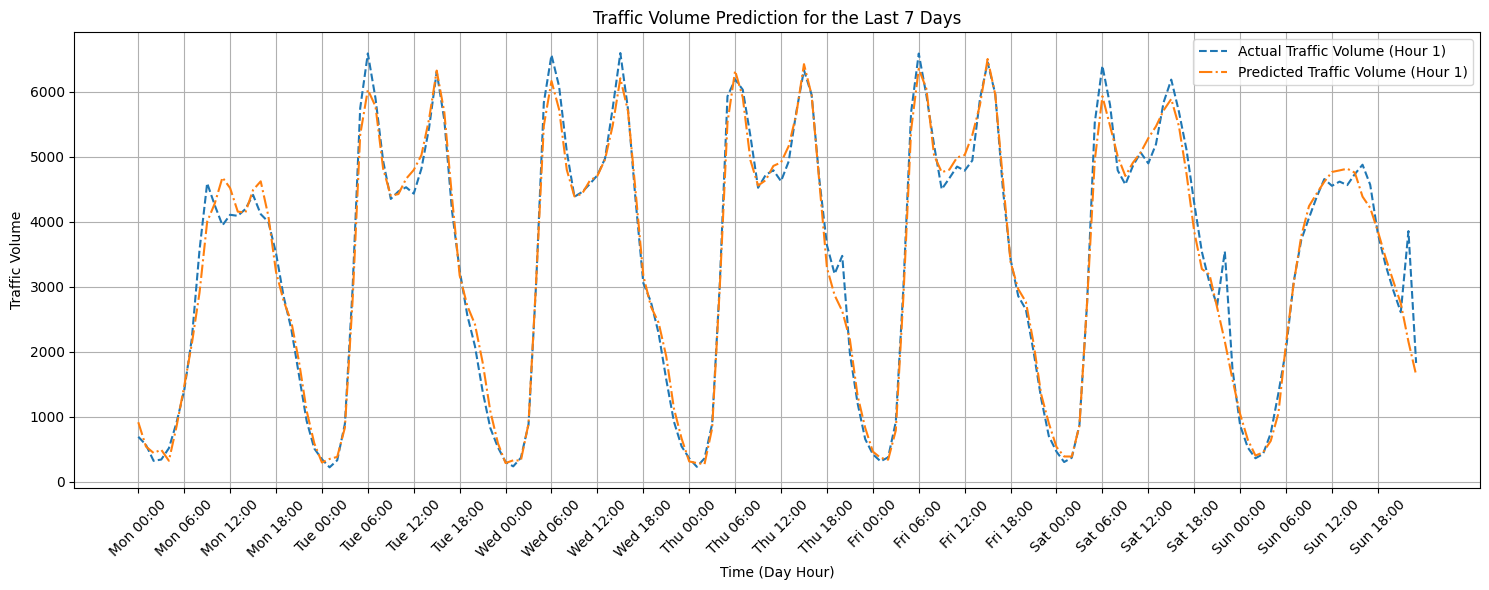

In [22]:
# Define the number of hours to plot
hours_to_plot = 168   # For 7 days

# Slice the data for the last `hours_to_plot` hours
y_test_plot = y_test_rescaled[-hours_to_plot:]
test_predict_plot = test_predict_rescaled[-hours_to_plot:]

# Generate corresponding timestamps for the last `hours_to_plot` hours
timestamps = data['Timestamp'][-hours_to_plot:].reset_index(drop=True)

# Extract days and hours from the timestamps for x-axis labeling
time_labels = [ts.strftime('%a %H:%M') for ts in timestamps]  # Format: "Day Hour:Minute"

# Plot predictions vs actual values for the last `hours_to_plot` hours
plt.figure(figsize=(15, 6))

plt.plot(y_test_plot[:, 0], label='Actual Traffic Volume (Hour 1)', linestyle='--')

plt.plot(test_predict_plot[:, 0], label='Predicted Traffic Volume (Hour 1)', linestyle='-.')


# Set x-ticks to correspond to the day-hour labels
plt.xticks(ticks=range(0, hours_to_plot, 6), labels=time_labels[::6], rotation=45)

# Enhance plot with labels and legend
plt.xlabel('Time (Day Hour)')
plt.ylabel('Traffic Volume')
plt.legend()
plt.title(f'Traffic Volume Prediction for the Last {hours_to_plot // 24} Days')
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# Define horizons for evaluation
horizons = range(1, 25)  # From 1-hour to 3-hour forecasts

# Initialize metrics dictionary
metrics = {
    "Training": {},
    "Testing": {}
}

# Loop through each forecast horizon
for i in horizons:
    # Training metrics for i-hour forecast
    train_mse = mean_squared_error(y_train_rescaled[:, i - 1], train_predict_rescaled[:, i - 1])
    train_mae = mean_absolute_error(y_train_rescaled[:, i - 1], train_predict_rescaled[:, i - 1])
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train_rescaled[:, i - 1], train_predict_rescaled[:, i - 1])

    # Testing metrics for i-hour forecast
    test_mse = mean_squared_error(y_test_rescaled[:, i - 1], test_predict_rescaled[:, i - 1])
    test_mae = mean_absolute_error(y_test_rescaled[:, i - 1], test_predict_rescaled[:, i - 1])
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test_rescaled[:, i - 1], test_predict_rescaled[:, i - 1])

    # Store metrics in the dictionary
    metrics["Training"][f"{i}-Hour"] = {"MSE": train_mse, "MAE": train_mae, "RMSE": train_rmse, "R2": train_r2}
    metrics["Testing"][f"{i}-Hour"] = {"MSE": test_mse, "MAE": test_mae, "RMSE": test_rmse, "R2": test_r2}

# Print the metrics in a formatted way
for dataset, forecast_metrics in metrics.items():
    print(f"\n{dataset} Evaluation Metrics:")
    for forecast, values in forecast_metrics.items():
        print(f"  {forecast} Forecast:")
        for metric, score in values.items():
            print(f"    {metric}: {score:.4f}")



Training Evaluation Metrics:
  1-Hour Forecast:
    MSE: 102541.1420
    MAE: 218.8602
    RMSE: 320.2205
    R2: 0.9732
  2-Hour Forecast:
    MSE: 110825.2697
    MAE: 219.5794
    RMSE: 332.9043
    R2: 0.9710
  3-Hour Forecast:
    MSE: 122871.1960
    MAE: 230.3975
    RMSE: 350.5299
    R2: 0.9678
  4-Hour Forecast:
    MSE: 127906.7642
    MAE: 230.9367
    RMSE: 357.6406
    R2: 0.9665
  5-Hour Forecast:
    MSE: 125653.6654
    MAE: 228.9074
    RMSE: 354.4766
    R2: 0.9671
  6-Hour Forecast:
    MSE: 129313.6302
    MAE: 237.1680
    RMSE: 359.6020
    R2: 0.9662
  7-Hour Forecast:
    MSE: 129277.5003
    MAE: 233.7114
    RMSE: 359.5518
    R2: 0.9662
  8-Hour Forecast:
    MSE: 131736.3484
    MAE: 235.7914
    RMSE: 362.9550
    R2: 0.9655
  9-Hour Forecast:
    MSE: 139889.5143
    MAE: 246.9604
    RMSE: 374.0181
    R2: 0.9634
  10-Hour Forecast:
    MSE: 134491.1840
    MAE: 238.0472
    RMSE: 366.7304
    R2: 0.9648
  11-Hour Forecast:
    MSE: 137180.1716
    MAE: